# 1.  Introduction and Business Problem

## 1.1  Background

### Access to hospitals can save lives.  In a medical emergency, the time taken to get to a hospital is often a critical factor in patient recovery.  The physical distance patients have to travel to get to a hospital is, therefore, crucially important.  In the United States, the quality of healthcare received often depends on the socioeconomic status of the patient.  Under the US healthcare framework, hospitals must operate in a fiscally responsible manner.  Even hospitals that are listed as Nonprofits must ensure that they are financially healthy.  This creates an incentive for hospitals to locate in wealthier neighborhoods, and avoid neighborhoods that are in lower-income areas.

## 1.2 Problem



###  I will explore whether there is any link between the physical distance one must travel to get to a hospital and the wealth of the person requiring treatment.  I would like to see whether hospitals are more likely to exist in wealthier districts as opposed to districts that are economically depressed.  For this exercise, I will focus on hospitals in Dallas, Texas.  I will explore whether any link exists between people's income and the physical distance they must travel to get to local hospitals.

## 1.3 Interest

### This information could be of interest to policymakers and hospital administrators who are looking to understand the scope of the issue and make decisions in the best interest of the public.

# 2. Data

## 2.1 Feature Selection

### I needed two primary pieces of information to complete this analysis:  income and hospital locations.  Then, we need a way to geo-locate this data.  

## 2.2 Data Sources

### The US Census publishes a report of income as reported in tax filings.  Kaggle has taken this data and compiled it into a user-friendly .csv format.  This data can be accessed with a Kaggle account at:

### https://www.kaggle.com/goldenoakresearch/us-household-income-stats-geo-locations

### The locations of hospitals were taken using Foursquare's API.  

## 2.2 Data Cleaning

### Both datasets required cleaning and, eventually, merging.  This was done using PANDAS software.  I filtered out extranious columns, as the datasets were quite large.  I selected the subset of data that applied to the Dallas Texas region.  I defined and removed "NaN" values (records in which no income data was available).  

# Methodology

### First I imported PANDAS and cleaned the data.  As mentioned above, this included dropping unnecessary columns, dropping rows with "NaN" values, and changing all data types to the correct format for analysis.  The following data table header summerizes the data from the Kaggle income table, cleaned up.  Note that we're using median income for each city, which has a corresponding latitude and logitude which will be used later.

In [272]:
import pandas as pd

#import csv and clean 
url_csv = 'http://www.sharecsv.com/dl/2be21221b8e609e6d691fb382e717221/DFW_income.csv'
cols = ['City', 'Zip_Code','Lat', 'Lon', 'Median']

data = pd.read_csv(url_csv, usecols = cols, na_values=0)
DFW = pd.DataFrame(data)
DFW = DFW.dropna()
DFW = DFW.drop(["Zip_Code"], axis=1)
DFW['Lat'] = DFW['Lat'].astype(float)
DFW['Lon'] = DFW['Lon'].astype(float)
DFW['Median'] = DFW['Median'].astype(float)

DFW.head()




,City,Lat,Lon,Median
0,Aledo,32.696186,-97.663302,120366.0
1,Bridgeport,33.209319,-97.772440,41754.0
2,Carrollton,32.988360,-96.899770,79305.0
3,Corsicana,32.081960,-96.467579,38775.0
4,Keene,32.355614,-97.292037,50201.0


### I then normalized the income data

In [273]:
#Normalize the Median Income data

DFW["Median"] = (DFW["Median"]-DFW["Median"].mean())/DFW["Median"].std()

DFW.head()


,City,Lat,Lon,Median
0,Aledo,32.696186,-97.663302,0.152540
1,Bridgeport,33.209319,-97.772440,-0.648920
2,Carrollton,32.988360,-96.899770,-0.266082
3,Corsicana,32.081960,-96.467579,-0.679291
4,Keene,32.355614,-97.292037,-0.562801


### Using Folium and the Folium heatmap plugin, I created a heatmap showing the dispersion of median incomes around the Dallas metro area.  Darker shades of green represent areas with high median incomes, and lighter shades represent areas with low income.  White spots represent rural areas with population too small to report.

In [281]:
#Create a heatmap of dallas, showing median income
import folium # map rendering library
from folium.plugins import HeatMap

map_dallas = folium.Map(location=[32.9, -97.0],
                        tiles = "Stamen Toner",
                        zoom_start = 10)

heat_data = [[row['Lat'],row['Lon'],row['Median']] for index, row in DFW.iterrows()]
HeatMap(heat_data, blur = 60, gradient = {0.4: 'green'}).add_to(map_dallas)

map_dallas


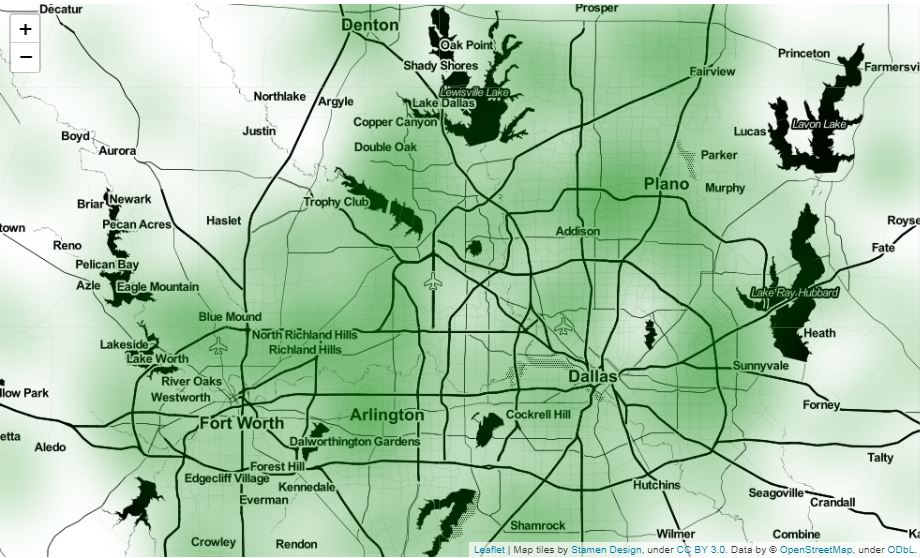

In [283]:
from IPython.display import Image
Image(filename="img/Map_1.JPG", width=2000, height=2000)

### Next, I imported the locations of Dallas-area hospitals using the Foursquare API.  I imported the data to a PANDAS dataframe.  I then cleaned the data, dropping unneeded columns.  The following table header shows a sample of the data extracted.

In [279]:
#Import data from foursquare and clean it

from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
import requests

CLIENT_ID = 'LJ4MZEMRIA30N533Y4VHDSQ2WAKOCZHUAXBWG2PL3BBDZUYQ' 
CLIENT_SECRET = 'PK3HBQGUTSIJPDXJA3PI5NUXT5E5HRYN4NSR1WAQ3CK2E5IU' 
VERSION = '20180605' 
latitude = 32.91
longitude = -96.79
radius = 80000
LIMIT = 100
intent = 'browse'
search_query = 'hospital'


url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&intent={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, intent, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()

venues = results['response']['venues']

dataframe = json_normalize(venues)

dataframe = dataframe[['name', 'location.lat', 'location.lng']]

dataframe = dataframe.drop(labels = 7, axis = 0)
dataframe = dataframe.drop(labels = 29, axis = 0)
dataframe.head()



,name,location.lat,location.lng
0,Medical City Children's Hospital,32.911987,-96.774639
1,Texas Health Presbyterian Hospital Dallas,32.881813,-96.763005
2,Parkland Health & Hospital System,32.813022,-96.835212
3,Green Oaks Hospital,32.913076,-96.772017
4,JPS Hospital,32.727128,-97.326021


###  Next, I overlayed the hospital locations on top of our income heatmap.  A visual inspection shows that hospitals appear to be clustered around areas of high income.

In [282]:
# put hospitals on our heatmap
# I am editing a copy of the original map, to work non-destructively

map_dallas2 = folium.Map(location=[32.9, -97.0],
                        tiles = "Stamen Toner",
                        zoom_start = 10)

heat_data = [[row['Lat'],row['Lon'],row['Median']] for index, row in DFW.iterrows()]
HeatMap(heat_data, blur = 60, gradient = {0.4: 'green'}).add_to(map_dallas2)

#adding our foursquare dataset of hospitals

for lat, lng, city, in zip(dataframe['location.lat'], dataframe['location.lng'], dataframe['name']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dallas2)  
    
map_dallas2

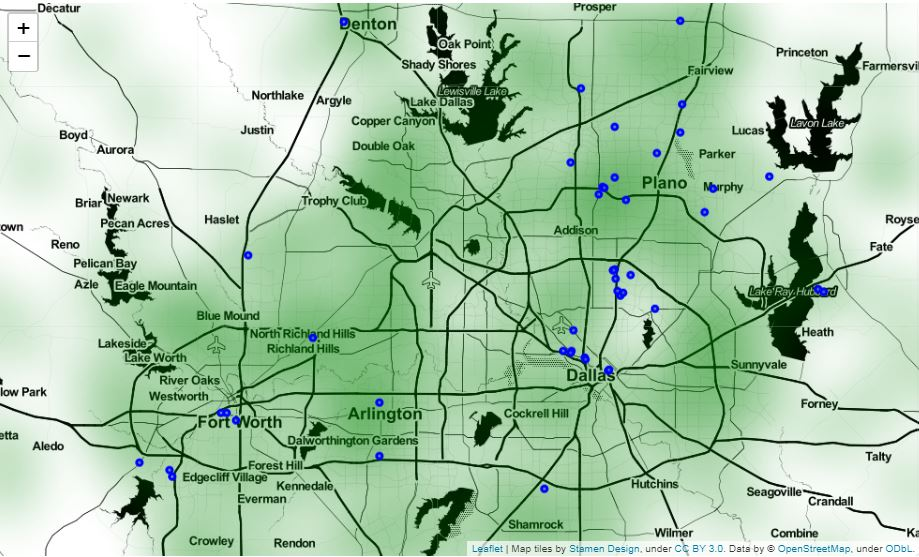

In [284]:
from IPython.display import Image
Image(filename="img/Map_2.JPG", width=2000, height=2000)

### Next, I combined the two dataframes.  I created a new column in the income dataframe to serve as a record number.  This is because in combining the dataframes, I am trying to find the distance from each income responder to each hospital on the list.  Each responder, therefore, now has his/her own unique Record Number.

In [249]:
#Combining the two dataframes


DFW['Record Number'] = range(len(DFW))
DFW['key'] = 1
dataframe['key'] = 1

Distances = pd.merge(DFW, dataframe, on='key').drop('key', axis=1)
Distances = Distances.rename(columns ={"City": "Cit_City", "Lat": "Cit_Lat", "Lon": "Cit_Lon", "name": "Hospital", "location.lat": "Hos_Lat", "location.lng": "Hos_Lon"})


Distances.head()

#DFW.to_excel(r'C:\Users\User\Desktop\test3.xlsx',sheet_name= 'foobar')


,Cit_City,Cit_Lat,Cit_Lon,Median,Record Number,Hospital,Hos_Lat,Hos_Lon
0,Aledo,32.696186,-97.663302,0.15254,0,Medical City Children's Hospital,32.911987,-96.774639
1,Aledo,32.696186,-97.663302,0.15254,0,Texas Health Presbyterian Hospital Dallas,32.881813,-96.763005
2,Aledo,32.696186,-97.663302,0.15254,0,Parkland Health & Hospital System,32.813022,-96.835212
3,Aledo,32.696186,-97.663302,0.15254,0,Green Oaks Hospital,32.913076,-96.772017
4,Aledo,32.696186,-97.663302,0.15254,0,JPS Hospital,32.727128,-97.326021


### Next, I use Python's "geopy.distance" library to calculate the distance between each respondant and each hospital.  This had to be done using a function.  The header of the resulting table is shown below.

In [250]:
#Calculating the average distance to each hospital

import geopy.distance

Distances['Distance'] = Distances.apply(
    (lambda row: geopy.distance.geodesic(
        (row['Cit_Lat'], row['Cit_Lon']),
        (row['Hos_Lat'], row['Hos_Lon'])
    ).mi),
    axis=1
)

Distances.head()

,Cit_City,Cit_Lat,Cit_Lon,Median,Record Number,Hospital,Hos_Lat,Hos_Lon,Distance
0,Aledo,32.696186,-97.663302,0.15254,0,Medical City Children's Hospital,32.911987,-96.774639,53.812973
1,Aledo,32.696186,-97.663302,0.15254,0,Texas Health Presbyterian Hospital Dallas,32.881813,-96.763005,53.941990
2,Aledo,32.696186,-97.663302,0.15254,0,Parkland Health & Hospital System,32.813022,-96.835212,48.886519
3,Aledo,32.696186,-97.663302,0.15254,0,Green Oaks Hospital,32.913076,-96.772017,53.980066
4,Aledo,32.696186,-97.663302,0.15254,0,JPS Hospital,32.727128,-97.326021,19.764394


### Finally, I normalized the calculated distances.

In [252]:
#Normalize the Distances

Distance_normal = Distances.copy()

Distance_normal["Distance"] = Distance_normal["Distance"]/Distance_normal["Distance"].max()

Distance_normal.head()

,Cit_City,Cit_Lat,Cit_Lon,Median,Record Number,Hospital,Hos_Lat,Hos_Lon,Distance
0,Aledo,32.696186,-97.663302,0.15254,0,Medical City Children's Hospital,32.911987,-96.774639,0.471591
1,Aledo,32.696186,-97.663302,0.15254,0,Texas Health Presbyterian Hospital Dallas,32.881813,-96.763005,0.472721
2,Aledo,32.696186,-97.663302,0.15254,0,Parkland Health & Hospital System,32.813022,-96.835212,0.428418
3,Aledo,32.696186,-97.663302,0.15254,0,Green Oaks Hospital,32.913076,-96.772017,0.473055
4,Aledo,32.696186,-97.663302,0.15254,0,JPS Hospital,32.727128,-97.326021,0.173205


# Results

### Applying a statistical analysis to the distances and median incomes, we find that in fact, there is a relationship.  Lower median income is significantly correlated with hospital distance.  

In [263]:
#Statistical analysis

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

x = Distance_normal["Median"]
y = Distance_normal["Distance"]

model = sm.OLS(y, x).fit()
predictions = model.predict(x)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               Distance   R-squared (uncentered):                   0.006
Model:                            OLS   Adj. R-squared (uncentered):              0.006
Method:                 Least Squares   F-statistic:                              164.0
Date:                Thu, 26 Mar 2020   Prob (F-statistic):                    1.86e-37
Time:                        21:17:27   Log-Likelihood:                         -5853.0
No. Observations:               29424   AIC:                                  1.171e+04
Df Residuals:                   29423   BIC:                                  1.172e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Median        -0.0221      0.002    -12.808      0.000      -0.025      -0.019
==============================================================================
Omnibus:                     3295.185   Durbin-Watson:                   0.203
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4562.191
Skew:                           0.898   Prob(JB):                         0.00
Kurtosis:                       3.706   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### We see that using least squares, the analysis returns a standard error of 0.002.  This implies that the relationship between income and distance to hospitals is statistically significant with 99% confidence interval.  The coefficient value is negative, implying that the lower one's income, the farther they live from a hospital.  On the other hand, we calculated a rather low R-squared value of 0.006.  This implies that although income may be one factor, other factors also influence hospital location.  

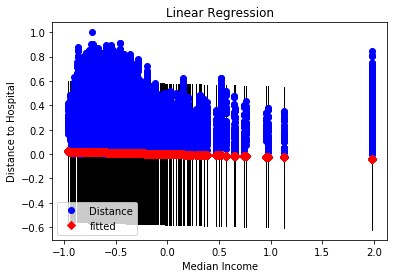

In [269]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(model, 0, ax=ax)
ax.set_ylabel("Distance to Hospital")
ax.set_xlabel("Median Income")
ax.set_title("Linear Regression")
plt.show()

### We continue this analysis by looking at the distance of each income respondent to the hospital nearest to them.  To do this, I used PANDAS groupby method.

### We see that using least squares, the analysis returns a standard error of 0.005.  This implies that the relationship between income and distance to hospitals is statistically significant with 99% confidence interval.  The coefficient value is negative, implying that the lower one's income, the farther they live from their nearest hospital.  While the R-squared value in this case was a bit higher at 0.018, this is still low.  This implies that while income is important, other factors also influence hospital location. 

In [280]:
#Distance of each record to closest hospital

Closest = Distance_normal[Distance_normal['Distance'] == Distance_normal.groupby('Record Number')['Distance'].transform('min')]
Closest = Closest.sort_values('Distance').drop_duplicates('Record Number')

a = Closest["Median"]
b = Closest["Distance"]

model2 = sm.OLS(b, a).fit()
predictions2 = model2.predict(a)

model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               Distance   R-squared (uncentered):                   0.018
Model:                            OLS   Adj. R-squared (uncentered):              0.016
Method:                 Least Squares   F-statistic:                              11.27
Date:                Thu, 26 Mar 2020   Prob (F-statistic):                    0.000838
Time:                        21:52:06   Log-Likelihood:                          416.62
No. Observations:                 613   AIC:                                     -831.2
Df Residuals:                     612   BIC:                                     -826.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Median        -0.0167      0.005     -3.357      0.001      -0.026      -0.007
==============================================================================
Omnibus:                      311.930   Durbin-Watson:                   0.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1455.240
Skew:                           2.378   Prob(JB):                         0.00
Kurtosis:                       8.862   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

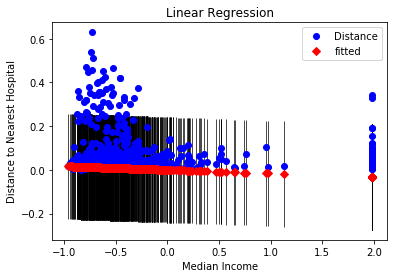

In [270]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(model2, 0, ax=ax)
ax.set_ylabel("Distance to Nearest Hospital")
ax.set_xlabel("Median Income")
ax.set_title("Linear Regression")
plt.show()

# Discussion

### As we have seen, there is a statistically significant relationship between median income and hospital distance.  However, as our low r-squared value shows, income is only one factor that models hospital location. In order to build a stronger model, we would want to look at other factors that could influence hospital location such as population, tax incentives to build hospitals, highway access, and other things.  

### We must also question whether Dallas is a good representation of the United States as a whole.  Further study would have to be done in other cities to see whether this is the case.

# Conclusion

###  The time taken to get to a hospital during a medical emergency is often a critical factor in patient recovery.  The physical distance patients have to travel to get to a hospital is, therefore, crucially important.  I hypothesized originally that  hospitals had a financial incentive to locate closer to upper-income areas, and expected to find that to be the case.   

###   In this analysis, I looked at whether there is any link between the physical distance one must travel to get to a hospital and the wealth of the person requiring treatment in Dallas, Texas. 

###  In the end, I did find a statistically significant link.  However, further studies would be required, as the data seems to show that other factors play a strong role in determining hospital locations.